In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' 
import numpy as np

#from GW_prot import *


import sys
sys.path.insert(0,'../src')

from FGW_protein import *
import stress_comparison
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib.patches as patches 

import mpl_toolkits.axisartist.floating_axes as floating_axes


The viral RNA-dependent RNA-polymerases (RdRps) contain some circularly permuted proteins - proteins where the same motifs or domains appear in different orders along the backbone. RdRps contain three active site motifs labelled A, B and C which typically appear in the order ABC but can also appear in the order CAB. We use 'ABC' and 'CAB' to denote these two different types of RdRps.

We first load 10 proteins of each types, whose PDB files were predicted using AlphaFold.

In [2]:
dir = '../Examples/Examples Data/Example 3/'
file_list = os.listdir(dir)
ABC_prots = [FGW_protein.make_protein_from_pdb(dir + file) for file in file_list[:10]]
CAB_prots = [FGW_protein.make_protein_from_pdb(dir + file) for file in file_list[10:]]

We then create a `stress_comparison.Stress_Comparison` object and run GW all-vs-all in it.

In [5]:
A = stress_comparison.Stress_Comparison(prot_list=ABC_prots + CAB_prots)
A.GW_compute_stresses()

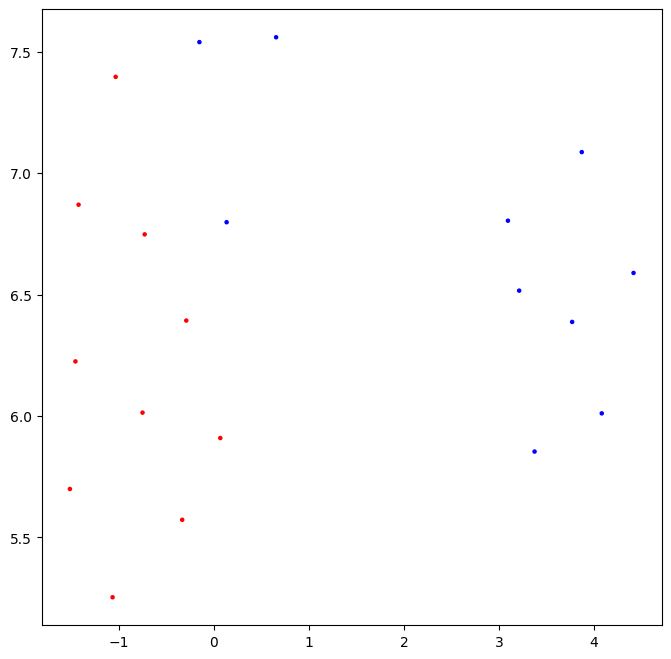

In [8]:
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
reducer = UMAP(metric = 'precomputed')
embedding = reducer.fit_transform(A.get_GW_dmat())
plt.figure(figsize=(8,8)) 
plt.scatter(embedding[:,0] ,embedding[:,1], color = ['red']*10 + ['blue']*10, s = 5)

#Pablo - try isomap here instead


If we look at the transport plan between two ABC proteins or two CAB proteins, we see that it is very similar to the identity matrix, meaning that the alignment given by GW is nearly just the sequential alignment.

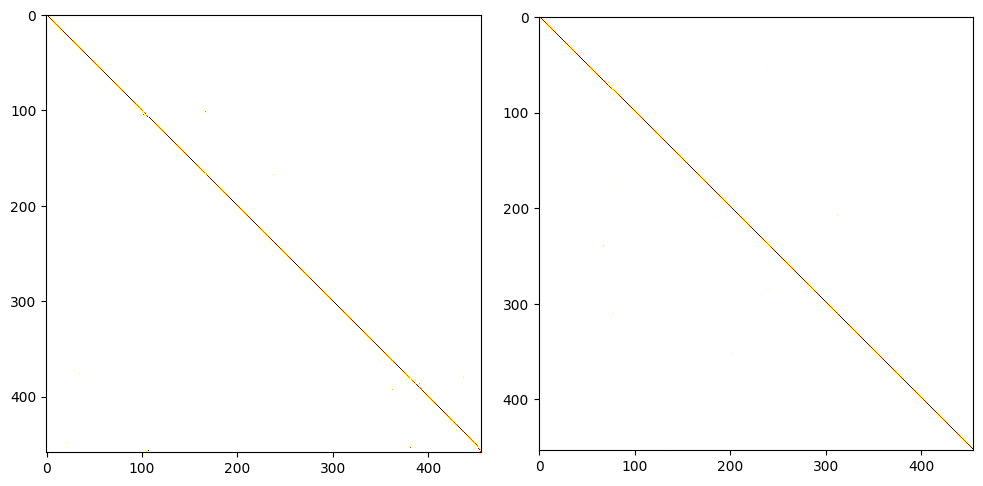

In [9]:
fig , axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
fig.tight_layout()

# two ABC proteins
axes[0].imshow(A.transport_dict[A.name_list[0]][A.name_list[1]], cmap = 'hot_r', label = 'ABC to ABC')

#two CAB proteins
axes[1].imshow(A.transport_dict[A.name_list[10]][A.name_list[11]], cmap = 'hot_r', label = 'CAB to CAB')
plt.show()



In contrast if we look at the transport plan between an ABC protein and a CAB protein it is close to being the identity matrix aside from

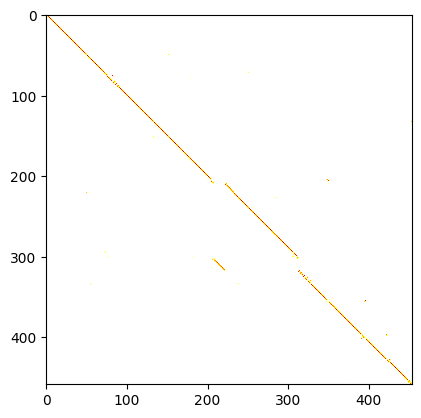

In [10]:
plt.imshow(A.transport_dict[A.name_list[0]][A.name_list[10]], cmap = 'hot_r', label = 'ABC to CAB'))
plt.show()

In pymol we can visualized the transport plan. `pymol_protein_viewer.compare_proteins_in_pymol` uses `weighted_alignment.weighted_RMSD` to superimpose the two proteins minimizign weighted RMSD. `compare_proteins_in_pymol` allows displays dashes between pairs of aligned residues.

In [17]:
import pymol_protein_viewer
pymol_protein_viewer.compare_proteins_in_pymol(
    file1 = dir + file_list[0], 
    file2 = dir + file_list[10],
    chain1 ='A', 
    chain2 ='A', 
    transport_plan=A.transport_dict[A.name_list[0]][A.name_list[10]], 
    output_file= 'Example3.pse') 

In this screenshot we see the two proteins overlaid. The transport plain is shown by the green lines between paired residues.

(insert image here)

We can use `FGW_protein.get_switch_prob_sparse` to see which residues are switched.


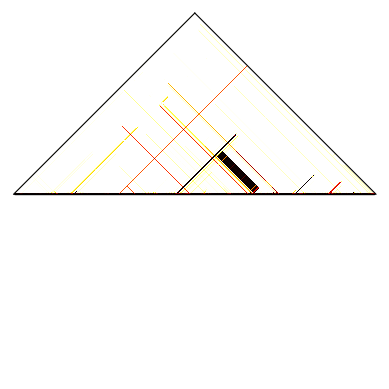

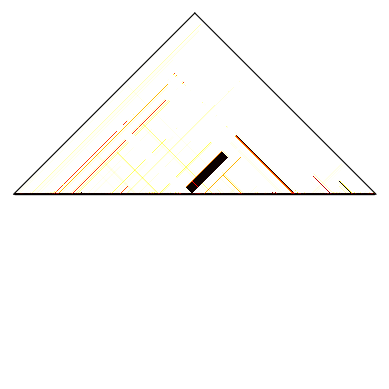

In [16]:
visualize_switch_probabibilities(switch_probs.get_switch_prob_sparse(A.transport_dict[A.name_list[0]][A.name_list[10]]))
visualize_switch_probabibilities(switch_probs.get_switch_prob_sparse(A.transport_dict[A.name_list[10]][A.name_list[0]]))


The white and light-colored areas represent pairs of residues whose orders are preserved and the dark rectangles are pairs whose orders are switched. Using `switch_probs.preprocess` and `switch_probs.max_rectangle_diagonal` we can find the size of the largest such rectangle for each pair of proteins. This can indicate whether two proteins have the same or different permutation types.


In [23]:
switch_score_mat = np.zeros((20,20))

for i in range(20):
    for j in range(20):
        if i ==j:
            continue

        T = A.transport_dict[A.name_list[i]][A.name_list[j]]

        #To do - rewrite this based on newer code
        SP0 = switch_probs.get_switch_prob_sparse(T)
        SP1 = np.triu(1 - switch_probs.preprocess_smooth(SP0)) 
        s = switch_probs.max_rectangle_diagonal(SP1)[0]
        switch_score_mat[i,j] = s


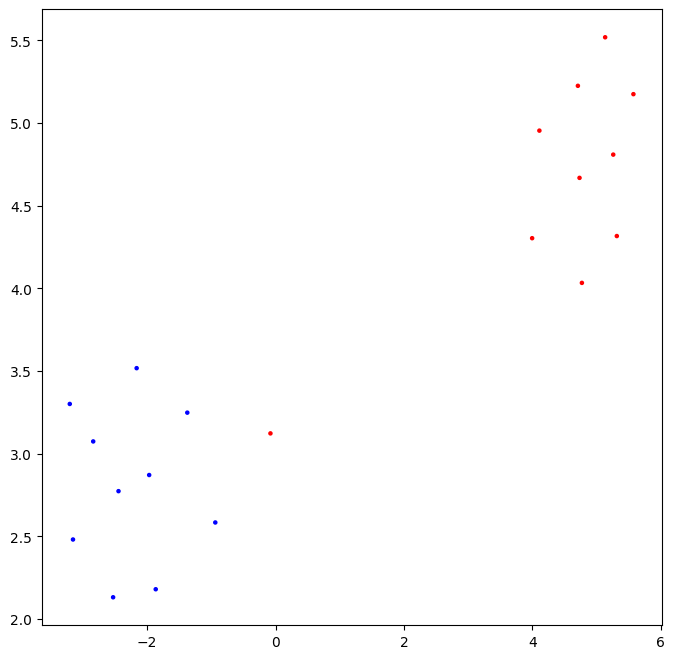

In [24]:
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
reducer = UMAP(metric = 'precomputed')
embedding = reducer.fit_transform(switch_score_mat)
plt.figure(figsize=(8,8)) 
plt.scatter(embedding[:,0] ,embedding[:,1], color = ['red']*10 + ['blue']*10, s = 5)